# **Problem statement**
-
Aim: The goal of this project is to develop a computer vision model capable of accurately detecting emotions from facial images. Utilizing a pre-processed dataset with labeled emotions, we will design and train a convolutional neural network (CNN) architecture. The model's performance will be evaluated primarily based on accuracy using a validation set, and the final trained model will be tested on a separate test set to assess its real-world performance. This project aims to showcase efficient model building, hyperparameter optimization, and evaluation techniques for emotion detection using deep learning.

Now, I'll proceed to develop the code for this project. Given the constraints, I'll aim for a simple yet effective CNN architecture and efficient hyperparameter tuning techniques to achieve the best performance. Let's start with data loading and preprocessing.

# Importing the required libraries

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%matplotlib inline
import seaborn as sns

In [ ]:
# seed ensures reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# I am mounting my drive because I uploaded the image dataset in the drive to work on colab
# because my local system dosent have enough graphic memory requirements, make sure the image zip file is uploaded in the drive prior to this step
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We can unzip the images.zip file using zipfile library
# the unzipped file is placed in a seperately created folder called 'extracted_folder'
# Make sure u give the correct zip_path as to where you have uploaded your images.zip file
# if u give wrong path or if your file is not images.zip, u might encounter errors
import zipfile

# Replace 'file_path.zip' with the path to your zip file
zip_path = '/content/drive/MyDrive/images.zip'

# Replace 'extracted_folder' with the folder where you want to extract the contents
extracted_folder = '/content/extracted_folder'

# Create the folder if it doesn't exist
!mkdir -p $extracted_folder

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)




# Loading the images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen=ImageDataGenerator()

In [ ]:
# give correct file paths for the extracted trai,.validation and test data
train_path='/content/extracted_folder/images/train'
val_path='/content/extracted_folder/images/validation'
test_path='/content/extracted_folder/images/final test'

In [ ]:
# My way of approaching any problem is loading the entire dataset, then splitting it into X and y,
# Here seed=123 ensure reproducibility again for shuffle
# target_size is 48,48 as I saw most images are for this size and hence dosen't need rescaling
train_data_generator=datagen.flow_from_directory(train_path,target_size=(48,48),class_mode='categorical',shuffle=True,batch_size=26921,seed=123)

Found 26921 images belonging to 7 classes.


In [ ]:
validation_data_generator=datagen.flow_from_directory(val_path,target_size=(48,48),class_mode='categorical',shuffle=True,batch_size=7099,seed=123)

Found 7066 images belonging to 7 classes.


In [ ]:
final_test_data_generator=datagen.flow_from_directory(test_path,target_size=(48,48),class_mode='categorical',shuffle=True,batch_size=1900,seed=123)

Found 1900 images belonging to 7 classes.


In [ ]:
# As mentioned early let us split train data to X_train and y_train
X_train,y_train=train_data_generator.next()

In [ ]:
# similarly X_val and y_val
X_val,y_val=validation_data_generator.next()

In [ ]:
# similarly X_test and y_test
# We will never touch this test data until final evaluation
X_test,y_test=final_test_data_generator.next()

In [ ]:
# Lets print the shape for train test and validation data
print('train X and y shape:{}{}'.format(X_train.shape,y_train.shape))
print('validation X and y shape:{}{}'.format(X_val.shape,y_val.shape))
print('test X and y shape:{}{}'.format(X_test.shape,y_test.shape))

train X and y shape:(26921, 48, 48, 3)(26921, 7)
validation X and y shape:(7066, 48, 48, 3)(7066, 7)
test X and y shape:(1900, 48, 48, 3)(1900, 7)


In [ ]:
# name of the classes
classes=list((train_data_generator.class_indices.keys()))
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Data visualization

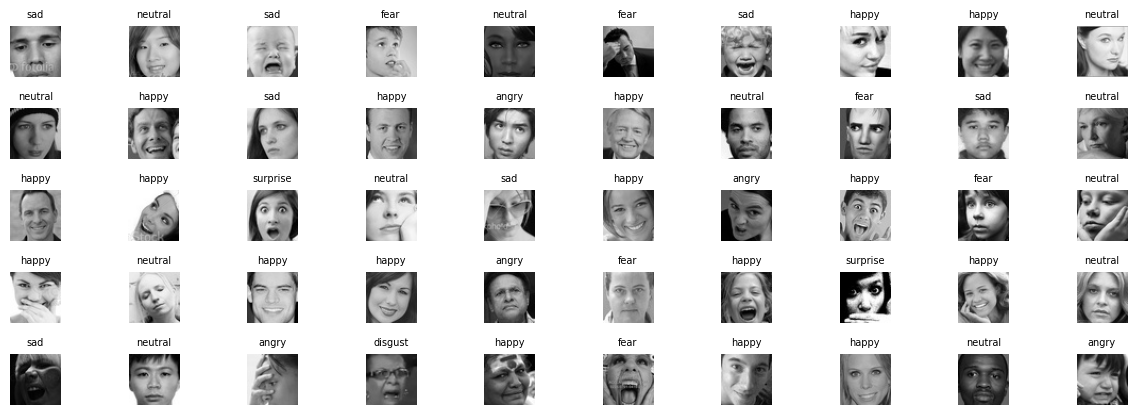

In [ ]:
# lets visualize 50 images from out train data
plt.figure(figsize=(12,10))
plotnumber=1
for i in range(50):
  plt.subplot(12,10,plotnumber)
  plt.imshow(X_train[i]/255) # because scale must be in between 1 and 0
  plt.axis('off')
  plt.title(classes[np.argmax(y_train[i])],fontsize=7)
  plotnumber+=1
plt.tight_layout()
plt.show()

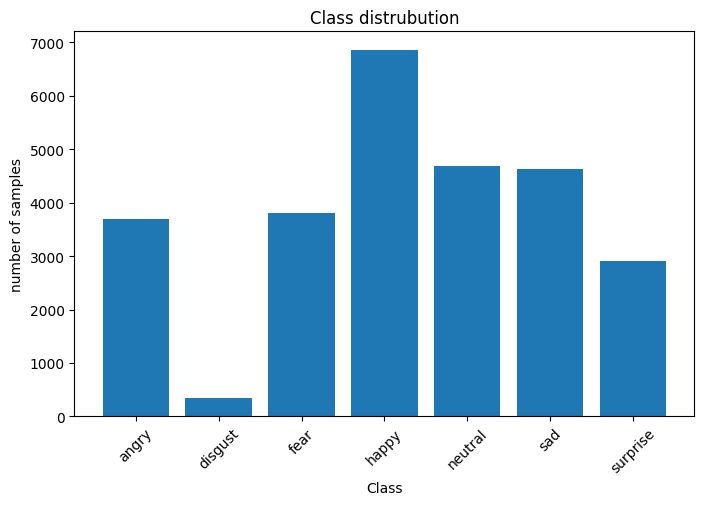

In [ ]:
# Let us visualize the class distribution
class_distribution=np.sum(y_train,axis=0)
plt.figure(figsize=(8,5))
plt.bar(range(len(class_distribution)),class_distribution)
plt.xlabel('Class')
plt.ylabel('number of samples')
plt.title('Class distrubution')
plt.xticks(range(len(class_distribution)),classes,rotation=45)
plt.show()

### Notes
- we can see that happy has the highes number of training instances with more than 6500 instances
- disgust has the least number of training instances with less than 500 images.
- This shows an imbalanced dataset

### Feature Scaling

In [ ]:
# Feature Scaling - must convert 0-255 to 0-1 for neural networks
X_train=X_train/255
X_train

array([[[[0.24705882, 0.24705882, 0.24705882],
         [0.3372549 , 0.3372549 , 0.3372549 ],
         [0.41568628, 0.41568628, 0.41568628],
         ...,
         [0.34509805, 0.34509805, 0.34509805],
         [0.21960784, 0.21960784, 0.21960784],
         [0.10588235, 0.10588235, 0.10588235]],

        [[0.27450982, 0.27450982, 0.27450982],
         [0.35686275, 0.35686275, 0.35686275],
         [0.43137255, 0.43137255, 0.43137255],
         ...,
         [0.32941177, 0.32941177, 0.32941177],
         [0.24313726, 0.24313726, 0.24313726],
         [0.12941177, 0.12941177, 0.12941177]],

        [[0.34117648, 0.34117648, 0.34117648],
         [0.39607844, 0.39607844, 0.39607844],
         [0.44313726, 0.44313726, 0.44313726],
         ...,
         [0.32941177, 0.32941177, 0.32941177],
         [0.27058825, 0.27058825, 0.27058825],
         [0.14117648, 0.14117648, 0.14117648]],

        ...,

        [[0.99215686, 0.99215686, 0.99215686],
         [0.99607843, 0.99607843, 0.99607843]

In [ ]:
#similarly
X_val=X_val/255
X_test=X_test/255  #Not touching this test data until final evaluation

# **Model Creation**

# Model1
- Lets try a simple model with 2 convoutional layers without any dropout, regularization or normalization
- We will compile it with adam optimizer

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten


model1=Sequential()

model1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(48,48,3)))
model1.add(MaxPool2D(2,2))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPool2D(2,2))

model1.add(Flatten())

model1.add(Dense(128,activation='relu'))

model1.add(Dense(7,activation='softmax')) # Softmax because it is classification task



In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               8

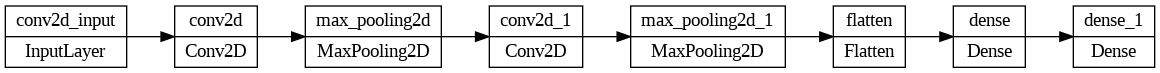

In [ ]:
# Just a visuzlization of model.sumary()
keras.utils.plot_model(model1,rankdir='LR')

In [ ]:
# we are just trying adam optimizer, and during training accuracy metric will be calculated,
#loss is 'categorical_cross_entropy' because of classification task
#Not using any callbacks as of now
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history1=model1.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),shuffle=True)

Epoch 1/30
842/842 [==============================] - 10s 7ms/step - loss: 1.5787 - accuracy: 0.3816 - val_loss: 1.4172 - val_accuracy: 0.4639
Epoch 2/30
842/842 [==============================] - 4s 5ms/step - loss: 1.3536 - accuracy: 0.4836 - val_loss: 1.3553 - val_accuracy: 0.4803
Epoch 3/30
842/842 [==============================] - 5s 6ms/step - loss: 1.2347 - accuracy: 0.5315 - val_loss: 1.2821 - val_accuracy: 0.5126
Epoch 4/30
842/842 [==============================] - 4s 5ms/step - loss: 1.1284 - accuracy: 0.5723 - val_loss: 1.2577 - val_accuracy: 0.5335
Epoch 5/30
842/842 [==============================] - 4s 5ms/step - loss: 1.0173 - accuracy: 0.6181 - val_loss: 1.2698 - val_accuracy: 0.5328
Epoch 6/30
842/842 [==============================] - 5s 6ms/step - loss: 0.9017 - accuracy: 0.6647 - val_loss: 1.2982 - val_accuracy: 0.5345
Epoch 7/30
842/842 [==============================] - 5s 6ms/step - loss: 0.7835 - accuracy: 0.7109 - val_loss: 1.3777 - val_accuracy: 0.5300
Epoch

In [ ]:
#lets create a function for the above for resuability
def evaluate(model):
  train_accuracy = model.evaluate(X_train, y_train,verbose=0)[1]
  val_accuracy = model.evaluate(X_val, y_val,verbose=0)[1]


  result ={
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }

  return result


In [ ]:
evaluate(model1)

{'train_accuracy': 0.9839901924133301, 'val_accuracy': 0.5169827342033386}

- We can see the model has significantly overfit the training set and performs poorly on the validation data

In [ ]:
model1.save_weights('/content/model1_51.hdf5')

In [ ]:
# history1.history returns a dictionary with loss and accuracy at each epochs
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

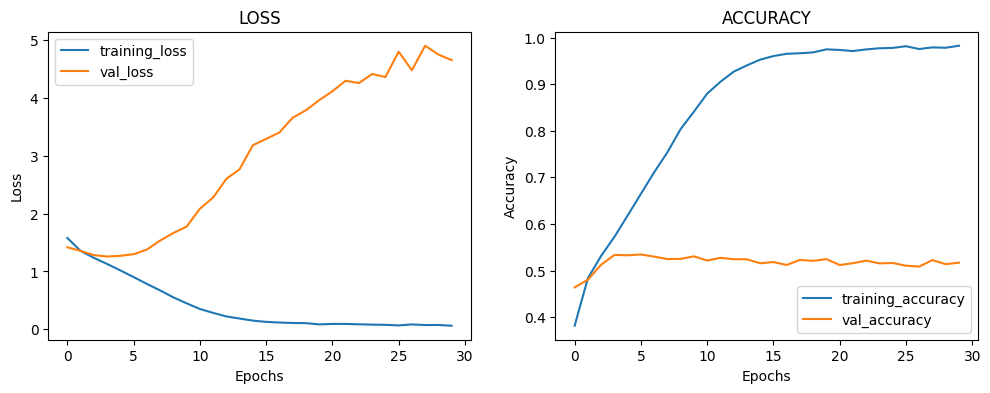

In [ ]:
# Lets plot loss and accuracy vs epochs for model1 with history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# plot for loss
plt.plot(history1.history['loss'],label='training_loss')
plt.plot(history1.history['val_loss'],label='val_loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot for accuracy
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'],label='training_accuracy')
plt.plot(history1.history['val_accuracy'],label='val_accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model2
- Lets try reducing the overfit of model1, using BatchNormalization and Dropout layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Dropout
from tensorflow.keras import regularizers



model2=Sequential()

model2.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(48,48,3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.5))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))

model2.add(Flatten())

model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(7,activation='softmax')) # Softmax because it is classification task

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 21, 21, 64)       

In [ ]:
#loss is 'categorical_cross_entropy' because of classification task
#Not using any callbacks as of now
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model2.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),shuffle=True)

Epoch 1/30
842/842 [==============================] - 12s 9ms/step - loss: 1.7770 - accuracy: 0.3433 - val_loss: 3.7488 - val_accuracy: 0.2799
Epoch 2/30
842/842 [==============================] - 7s 8ms/step - loss: 1.4816 - accuracy: 0.4294 - val_loss: 3.8778 - val_accuracy: 0.3818
Epoch 3/30
842/842 [==============================] - 7s 9ms/step - loss: 1.4640 - accuracy: 0.4397 - val_loss: 3.2878 - val_accuracy: 0.3772
Epoch 4/30
842/842 [==============================] - 6s 8ms/step - loss: 1.3869 - accuracy: 0.4652 - val_loss: 3.0891 - val_accuracy: 0.4237
Epoch 5/30
842/842 [==============================] - 7s 9ms/step - loss: 1.3448 - accuracy: 0.4814 - val_loss: 1.5099 - val_accuracy: 0.4195
Epoch 6/30
842/842 [==============================] - 6s 8ms/step - loss: 1.3491 - accuracy: 0.4824 - val_loss: 1.3301 - val_accuracy: 0.4908
Epoch 7/30
842/842 [==============================] - 7s 9ms/step - loss: 1.2962 - accuracy: 0.5050 - val_loss: 1.4454 - val_accuracy: 0.5014
Epoch

In [ ]:
evaluate(model2)

{'train_accuracy': 0.8390847444534302, 'val_accuracy': 0.5641098022460938}

In [ ]:
model2.save_weights('/content/model2_56.hdf5')

In [ ]:
# history1.history returns a dictionary with loss and accuracy at each epochs
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

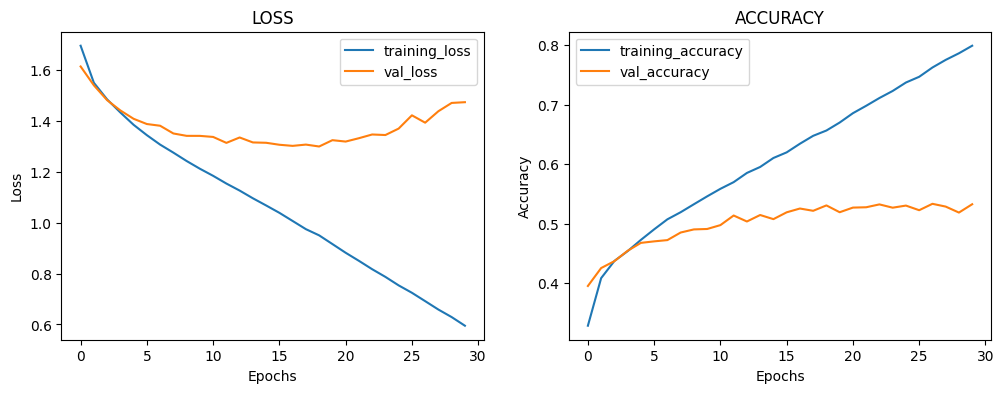

In [ ]:
# Lets plot loss and accuracy vs epochs for model2 with history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# plot for loss
plt.plot(history2.history['loss'],label='training_loss')
plt.plot(history2.history['val_loss'],label='val_loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot for accuracy
plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'],label='training_accuracy')
plt.plot(history2.history['val_accuracy'],label='val_accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model3
- we can see that the previous two models overfits the train set to a great extend
- to solve the issue, we can artificially increase the size of train data using a technique called Data Augmentation
- We are also changing the model architecture by introducing l2 penalty to some layers to reduce overfitting and improve regularization
- BatchNormalization and dropout layers are also used are experimented

In [ ]:
train_datagen = ImageDataGenerator(
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         validation_split = 0.2
                                        )

In [ ]:
augmented_data=train_datagen.flow(X_train,y_train,batch_size=64) #This is the augmented train data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers

model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))


In [ ]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_18 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
from keras.optimizers import Adam
model3.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
# applying modelcheckpointer and earlystopping callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping

early=EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)
check_pointer=ModelCheckpoint(filepath='model3.weights.best.hdf5',monitor='val_accuracy',save_best_only=True)

In [ ]:
history3 = model3.fit(augmented_data,epochs = 60,validation_data = (X_val,y_val),callbacks=[check_pointer])

Epoch 1/60
421/421 [==============================] - ETA: 0s - loss: 9.2051 - accuracy: 0.1956

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


421/421 [==============================] - 42s 88ms/step - loss: 9.2051 - accuracy: 0.1956 - val_loss: 8.7212 - val_accuracy: 0.2328
Epoch 2/60
421/421 [==============================] - 36s 86ms/step - loss: 8.0300 - accuracy: 0.2424 - val_loss: 7.2836 - val_accuracy: 0.3095
Epoch 3/60
421/421 [==============================] - 34s 81ms/step - loss: 6.9065 - accuracy: 0.2767 - val_loss: 6.2898 - val_accuracy: 0.3064
Epoch 4/60
421/421 [==============================] - 37s 89ms/step - loss: 5.8497 - accuracy: 0.3055 - val_loss: 5.2961 - val_accuracy: 0.3508
Epoch 5/60
421/421 [==============================] - 34s 81ms/step - loss: 4.9192 - accuracy: 0.3397 - val_loss: 4.3269 - val_accuracy: 0.4222
Epoch 6/60
421/421 [==============================] - 39s 94ms/step - loss: 4.1571 - accuracy: 0.3700 - val_loss: 3.7058 - val_accuracy: 0.4263
Epoch 7/60
421/421 [==============================] - 52s 124ms/step - loss: 3.5421 - accuracy: 0.3957 - val_loss: 3.2217 - val_accuracy: 0.4290
Ep

In [ ]:
evaluate(model3)

{'train_accuracy': 0.7387169599533081, 'val_accuracy': 0.6730823516845703}

In [ ]:
model3.save_weights('/content/model3_67.hdf5')

In [ ]:
# history1.history returns a dictionary with loss and accuracy at each epochs
history3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

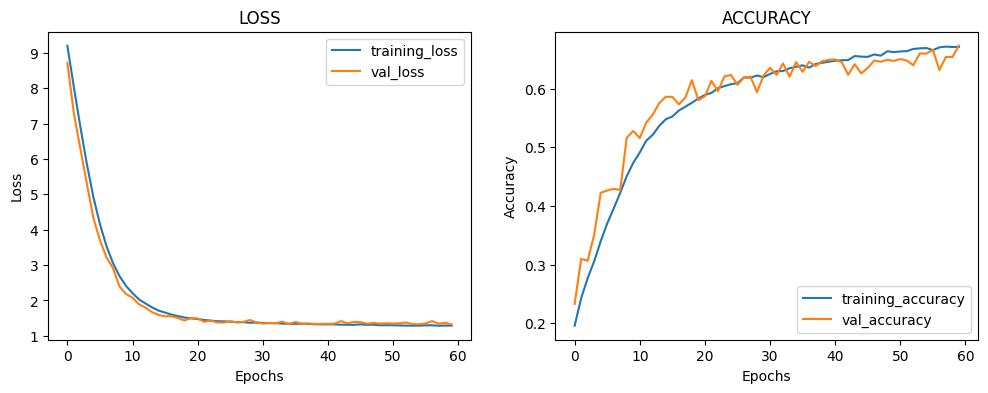

In [ ]:
# Lets plot loss and accuracy vs epochs for model3 with history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# plot for loss
plt.plot(history3.history['loss'],label='training_loss')
plt.plot(history3.history['val_loss'],label='val_loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot for accuracy
plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'],label='training_accuracy')
plt.plot(history3.history['val_accuracy'],label='val_accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model4 -Transfer Learning with Pretrained model-MobileNet

- MobileNet is a comparitevely smaller pretrained model with around 4.3M parameters. The model is pretrained on millions of images from the imagenet dataset
- We we try to use this pretrained model with some modifications for our task

In [ ]:
from keras.applications import MobileNet
from keras import Model
from keras.layers import GlobalAveragePooling2D,Dense

base_model=MobileNet(weights='imagenet',include_top=False,input_shape=(48,48,3))# input_shape must be same as our dataset's shape

avg=GlobalAveragePooling2D()(base_model.output)
x=Dense(256,activation='relu')(avg)
output=Dense(7,activation='softmax')(x)

model4=Model(inputs=base_model.input,outputs=output)

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 24, 24, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 24, 24, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 24, 24, 32)        128 

In [ ]:
base_model.input

<KerasTensor: shape=(None, 48, 48, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
# Let us freeze all the layers of the basemodel(ie MobileNet ) except its last 5 layers
# the last 5 layers of the base model and the remaining layers defined for model4 will take part in the training process and hence its weights and biases will be updated
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# applying modelcheckpointer and earlystopping callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping

early=EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)
check_pointer=ModelCheckpoint(filepath='model4.weights.best.hdf5',monitor='val_accuracy',save_best_only=True)

In [ ]:
from keras.optimizers import Adam
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history4=model4.fit(augmented_data,epochs=30,validation_data=(X_val,y_val),batch_size=64,steps_per_epoch=len(X_train)//64,callbacks=[check_pointer])# we are only taking modelcheckpointer as callback

Epoch 1/30
420/420 [==============================] - 33s 67ms/step - loss: 1.6527 - accuracy: 0.3745 - val_loss: 1.5487 - val_accuracy: 0.4015


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
420/420 [==============================] - 25s 60ms/step - loss: 1.4857 - accuracy: 0.4221 - val_loss: 1.5073 - val_accuracy: 0.4200
Epoch 3/30
420/420 [==============================] - 24s 57ms/step - loss: 1.4459 - accuracy: 0.4383 - val_loss: 1.4507 - val_accuracy: 0.4468
Epoch 4/30
420/420 [==============================] - 24s 56ms/step - loss: 1.4095 - accuracy: 0.4570 - val_loss: 1.5120 - val_accuracy: 0.4365
Epoch 5/30
420/420 [==============================] - 25s 59ms/step - loss: 1.3905 - accuracy: 0.4622 - val_loss: 1.5004 - val_accuracy: 0.4331
Epoch 6/30
420/420 [==============================] - 25s 61ms/step - loss: 1.3645 - accuracy: 0.4734 - val_loss: 1.4113 - val_accuracy: 0.4601
Epoch 7/30
420/420 [==============================] - 26s 63ms/step - loss: 1.3457 - accuracy: 0.4837 - val_loss: 1.4246 - val_accuracy: 0.4524
Epoch 8/30
420/420 [==============================] - 24s 58ms/step - loss: 1.3238 - accuracy: 0.4912 - val_loss: 1.4528 - val_accuracy:

In [ ]:
evaluate(model4)

{'train_accuracy': 0.648155689239502, 'val_accuracy': 0.47509199380874634}

In [ ]:
model4.save_weights('/content/model4_48.hdf5')

In [ ]:
# history1.history returns a dictionary with loss and accuracy at each epochs
history4.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

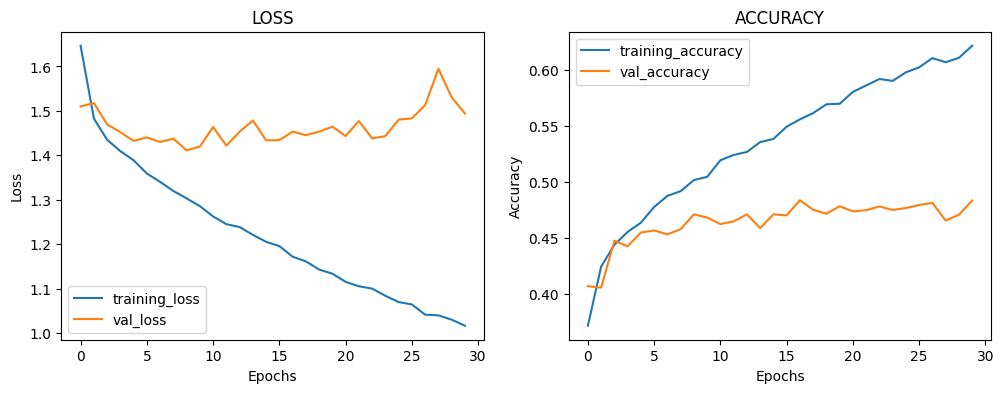

In [ ]:
# Lets plot loss and accuracy vs epochs for model4 with history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# plot for loss
plt.plot(history4.history['loss'],label='training_loss')
plt.plot(history4.history['val_loss'],label='val_loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot for accuracy
plt.subplot(1,2,2)
plt.plot(history4.history['accuracy'],label='training_accuracy')
plt.plot(history4.history['val_accuracy'],label='val_accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# model5 Transfer Learning using Resnet50

In [ ]:
from keras.applications import ResNet50
from keras import Model
from keras.layers import GlobalAveragePooling2D,Dense

base_model_res=ResNet50(weights='imagenet',include_top=False,input_shape=(48,48,3))


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Describing the model architecture
# Along with reusing the pretrained model, we are also adding a sequential model which aims to improve the model performance using,
# batch normalization dropout and activation layers along with each Dense layers
from keras import Model
from keras.layers import GlobalAveragePooling2D,Dense,Activation

model5=Sequential()
model5.add(base_model_res)

model5=Sequential()
model5.add(base_model)
model5.add(Dropout(0.5))

model5.add(Flatten())

model5.add(BatchNormalization())
model5.add(Dense(32))

model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(32))

model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(32))

model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dense(7,activation='softmax'))

In [ ]:
for layer in base_model_res.layers[:-4]:# All layers except the last 5 layers of the basemodel is freezed
  layer.trainable=False

In [ ]:
model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 1, 1, 1024)        0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_12 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 32)                32800     
                                                                 
 batch_normalization_13 (Ba  (None, 32)               

In [ ]:
# applying modelcheckpointer and earlystopping callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping

early=EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)
check_pointer=ModelCheckpoint(filepath='model5.weights.best.hdf5',monitor='val_accuracy',save_best_only=True)

In [ ]:
from keras.optimizers import Adam
model5.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history5=model5.fit(augmented_data,epochs=60,validation_data=(X_val,y_val),batch_size=64,steps_per_epoch=len(X_train)//64,callbacks=[check_pointer])

Epoch 1/60
420/420 [==============================] - 34s 64ms/step - loss: 1.8247 - accuracy: 0.2603 - val_loss: 1.6315 - val_accuracy: 0.3583
Epoch 2/60
420/420 [==============================] - 25s 60ms/step - loss: 1.6636 - accuracy: 0.3334 - val_loss: 1.5434 - val_accuracy: 0.4142
Epoch 3/60
420/420 [==============================] - 26s 61ms/step - loss: 1.6025 - accuracy: 0.3701 - val_loss: 1.5054 - val_accuracy: 0.4260
Epoch 4/60
420/420 [==============================] - 26s 61ms/step - loss: 1.5723 - accuracy: 0.3896 - val_loss: 1.4875 - val_accuracy: 0.4292
Epoch 5/60
420/420 [==============================] - 27s 65ms/step - loss: 1.5466 - accuracy: 0.4024 - val_loss: 1.4718 - val_accuracy: 0.4416
Epoch 6/60
420/420 [==============================] - 25s 59ms/step - loss: 1.5366 - accuracy: 0.4091 - val_loss: 1.4672 - val_accuracy: 0.4530
Epoch 7/60
420/420 [==============================] - 26s 63ms/step - loss: 1.5225 - accuracy: 0.4175 - val_loss: 1.4565 - val_accuracy:

In [ ]:
model5.save_weights('model5_freezed_49.hdf5')

In [ ]:
evaluate(model5)

{'train_accuracy': 0.5755729675292969, 'val_accuracy': 0.4905179738998413}

In [ ]:
# Now lets undfreeze the layers of the base model and fine tune the model
for layer in base_model_res.layers:
  layer.trainable=True

In [ ]:
#Fine tuning is usually done with a lower learning rate
from keras.optimizers import Adam
model5.compile(loss='categorical_crossentropy',optimizer=Adam(0.01),metrics=['accuracy'])

In [ ]:
history5=model5.fit(augmented_data,epochs=10,validation_data=(X_val,y_val),batch_size=64,steps_per_epoch=len(X_train)//64,callbacks=[check_pointer])

Epoch 1/10
419/420 [============================>.] - ETA: 0s - loss: 1.5434 - accuracy: 0.4096

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


420/420 [==============================] - 31s 63ms/step - loss: 1.5434 - accuracy: 0.4095 - val_loss: 1.4924 - val_accuracy: 0.4390
Epoch 2/10
420/420 [==============================] - 26s 61ms/step - loss: 1.5366 - accuracy: 0.4127 - val_loss: 1.4899 - val_accuracy: 0.4396
Epoch 3/10
420/420 [==============================] - 36s 86ms/step - loss: 1.5456 - accuracy: 0.4096 - val_loss: 1.4821 - val_accuracy: 0.4537
Epoch 4/10
420/420 [==============================] - 27s 65ms/step - loss: 1.5400 - accuracy: 0.4104 - val_loss: 1.4833 - val_accuracy: 0.4451
Epoch 5/10
420/420 [==============================] - 29s 69ms/step - loss: 1.5372 - accuracy: 0.4150 - val_loss: 1.4892 - val_accuracy: 0.4519
Epoch 6/10
420/420 [==============================] - 31s 73ms/step - loss: 1.5316 - accuracy: 0.4189 - val_loss: 1.4811 - val_accuracy: 0.4452
Epoch 7/10
420/420 [==============================] - 34s 82ms/step - loss: 1.5206 - accuracy: 0.4210 - val_loss: 1.4713 - val_accuracy: 0.4533
Epo

In [ ]:
evaluate(model5)

{'train_accuracy': 0.4824115037918091, 'val_accuracy': 0.45485422015190125}

- Fine tuning decreased the val accuracy which was not expected

# Model6
- let us try an architecture with same padding
- most importantly let us try using a call back provied by keras called ReduceLROnPlateau hat automatically adjusts the learning rate during training based on the validation loss or metric.
- The purpose of this callback is to help optimize the training process by reducing the learning rate when the model's performance on the validation set stops improving.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation

model6 = Sequential()

# Conv Block 1
model6.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,3)))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.25))

# Conv Block 2
model6.add(Conv2D(128,(5,5), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.25))

# Conv Block 3
model6.add(Conv2D(512,(3,3), padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.25))

model6.add(Flatten())

# Fully connected Block 1
model6.add(Dense(256))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.25))

# Fully connected Block 2
model6.add(Dense(512))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(Dropout(0.25))

model6.add(Dense(7, activation='softmax'))


In [ ]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_13 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_3 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
model6.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model_weights_m6.h5",monitor='val_accuracy',save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')
# factor: determines by what factor learning rate will be reduced
#min_lr:sets the lower bound for the learning rate.

In [ ]:
history6 = model6.fit(augmented_data,epochs=50,validation_data=(X_val,y_val),batch_size=64,steps_per_epoch=len(X_train)//64,callbacks=[checkpoint,reduce_lr])

Epoch 1/50
420/420 [==============================] - ETA: 0s - loss: 1.8396 - accuracy: 0.2889
Epoch 1: saving model to model_weights_m6.h5
420/420 [==============================] - 38s 79ms/step - loss: 1.8396 - accuracy: 0.2889 - val_loss: 2.0135 - val_accuracy: 0.2332 - lr: 5.0000e-04
Epoch 2/50
420/420 [==============================] - ETA: 0s - loss: 1.5820 - accuracy: 0.3837
Epoch 2: saving model to model_weights_m6.h5
420/420 [==============================] - 28s 67ms/step - loss: 1.5820 - accuracy: 0.3837 - val_loss: 1.5465 - val_accuracy: 0.4307 - lr: 5.0000e-04
Epoch 3/50
420/420 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.4410
Epoch 3: saving model to model_weights_m6.h5
420/420 [==============================] - 29s 68ms/step - loss: 1.4510 - accuracy: 0.4410 - val_loss: 1.3537 - val_accuracy: 0.4761 - lr: 5.0000e-04
Epoch 4/50
420/420 [==============================] - ETA: 0s - loss: 1.3646 - accuracy: 0.4741
Epoch 4: saving model to model_

In [ ]:
evaluate(model6)

{'train_accuracy': 0.6810668110847473, 'val_accuracy': 0.6360033750534058}

In [ ]:
model6.save_weights('/content/model6_63.hdf5')

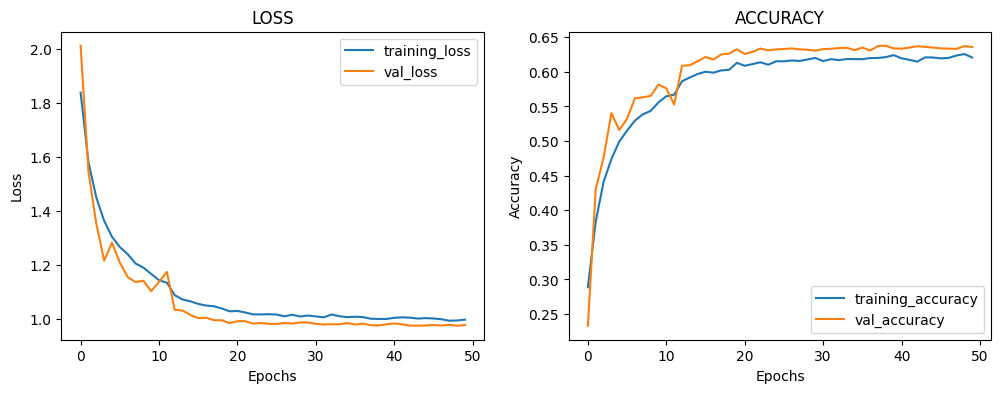

In [ ]:
# Lets plot loss and accuracy vs epochs for model1 with history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# plot for loss
plt.plot(history6.history['loss'],label='training_loss')
plt.plot(history6.history['val_loss'],label='val_loss')
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot for accuracy
plt.subplot(1,2,2)
plt.plot(history6.history['accuracy'],label='training_accuracy')
plt.plot(history6.history['val_accuracy'],label='val_accuracy')
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **Model Comparison report**

In [ ]:
import pandas as pd
models = [model1, model2, model3, model4, model5,model6]

# Creating a DataFrame
df = pd.DataFrame({
    'models': ['model1', 'model2', 'model3', 'model4', 'model5','model6'],
    'train_accuracy': [evaluate(model)['train_accuracy'] for model in models],# using list comprehension
    'val_accuracy': [evaluate(model)['val_accuracy'] for model in models]
})

In [ ]:
df.sort_values('val_accuracy',ascending=False)

,models,train_accuracy,val_accuracy
2,model3,0.738717,0.673082
5,model6,0.681104,0.635862
1,model2,0.839085,0.564110
0,model1,0.983990,0.516983
4,model5,0.575573,0.490518
3,model4,0.587014,0.470846


## Conclusion on val accuracy

- We can see that model3 ie model which we introduced Data Augmentation and L2 regularization penalty, performs the best for the validation data
- Model6, where we introduced ReduceLROnPlateau also performs decently on the validation
- Considering the complexity of the task 67% accuracy on validation data can be considered good

# Let us evaluate model3 on the Test data
- The test data is completely unseen by the model
- This will give an idea on how the model really performs on unseen data

In [ ]:
model3.evaluate(X_test,y_test)

60/60 [==============================] - 1s 14ms/step - loss: 1.4449 - accuracy: 0.6453


[1.4449321031570435, 0.645263135433197]

In [ ]:
Test_loss,Test_accuracy=model3.evaluate(X_test,y_test)
print('test loss:{} and test accuracy:{}'.format(Test_loss,Test_accuracy))

60/60 [==============================] - 1s 8ms/step - loss: 1.4449 - accuracy: 0.6453
test loss:1.4449321031570435 and test accuracy:0.645263135433197


In [ ]:
y_pred3=model3.predict(X_test)

60/60 [==============================] - 1s 6ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred3,axis=1)))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       300
           1       0.89      0.47      0.61       100
           2       0.60      0.42      0.50       300
           3       0.77      0.87      0.81       300
           4       0.54      0.73      0.62       300
           5       0.50      0.62      0.55       300
           6       0.84      0.75      0.79       300

    accuracy                           0.65      1900
   macro avg       0.68      0.63      0.64      1900
weighted avg       0.66      0.65      0.64      1900



- The recall for class 1 is less than 0.5, it might be because of the least amount of test samples

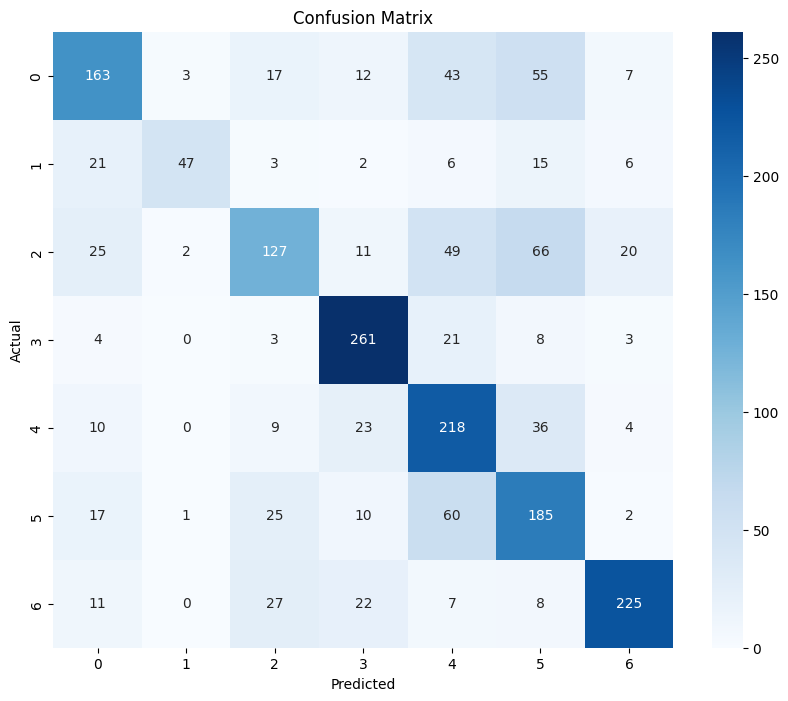

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred3, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4', '5', '6'], yticklabels=['0', '1', '2', '3', '4', '5', '6'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

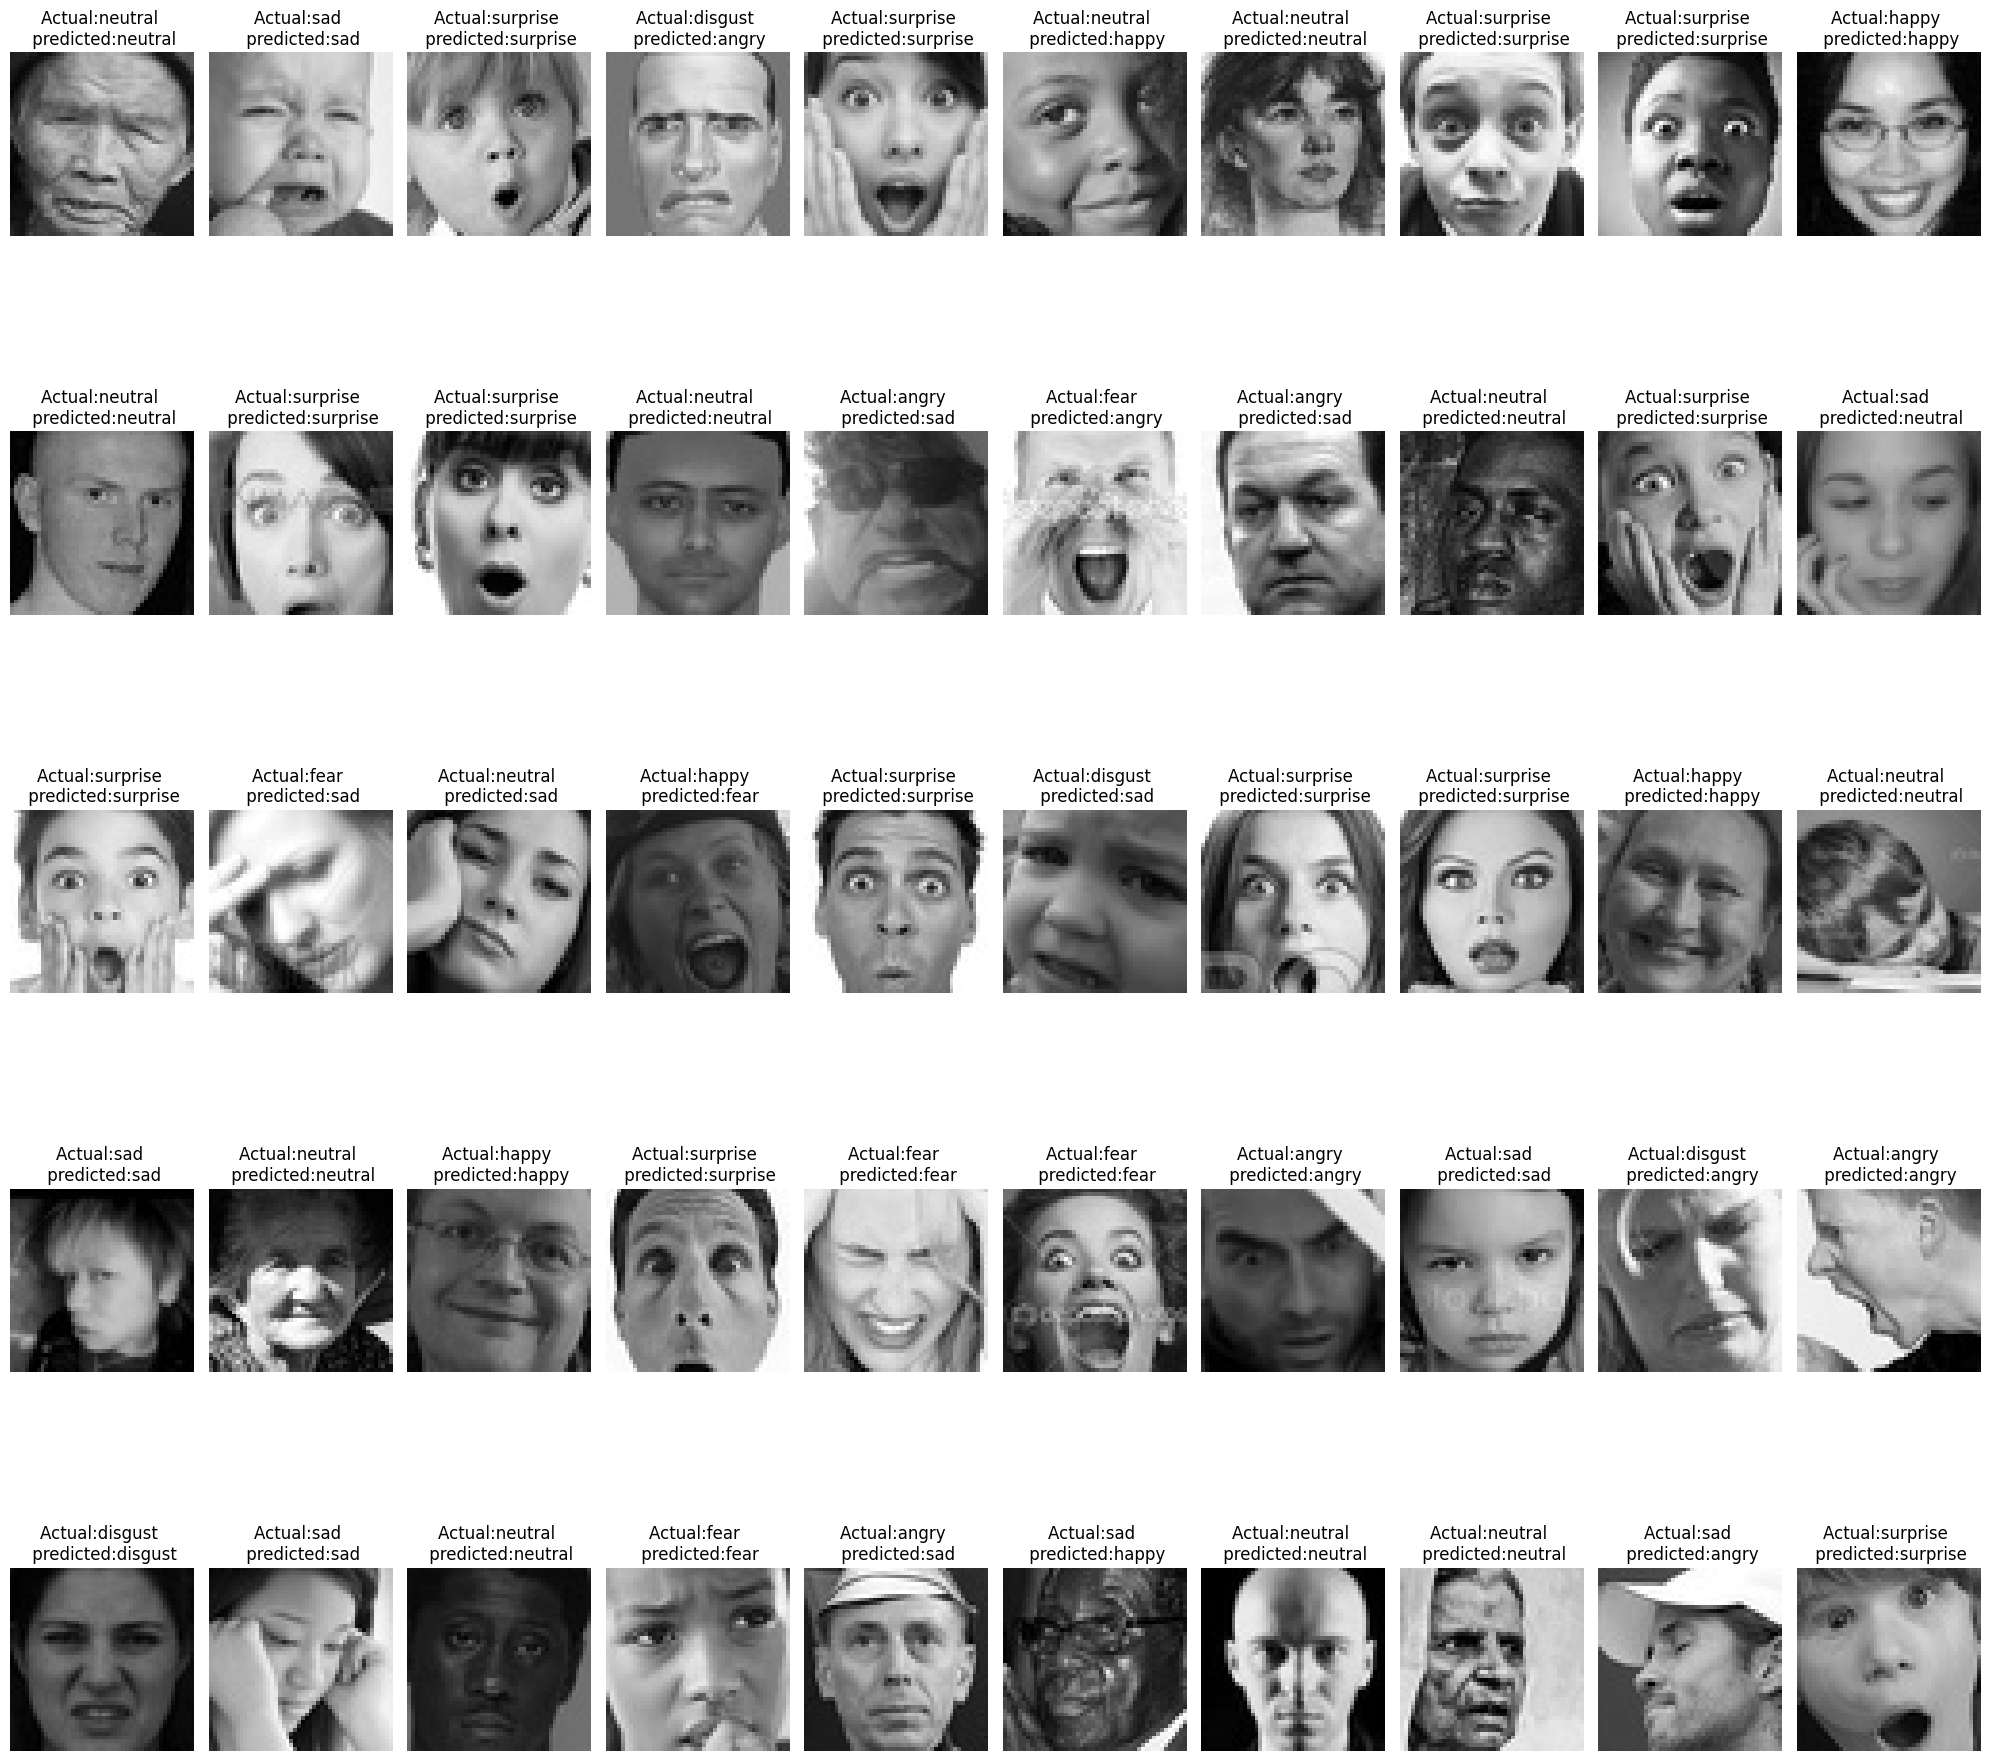

In [ ]:
#  Now lets visualize 50 of the actual test data and its predictions made by model3
plt.figure(figsize=(20,20))
plotnumber=1
for i in range(50):
  plt.subplot(5,10,plotnumber)
  plt.imshow(X_test[i])
  plt.axis('off')
  plt.title(f'Actual:{classes[np.argmax(y_test[i])]} \n predicted:{classes[np.argmax(y_pred3[i])]}')

  plotnumber+=1
plt.tight_layout()
plt.show()

# Conclusion

- We can see that the test accuracy is around 64.5% ,which is close to the validation accuracy
- This shows that the model pretty generalises well on new unseen data
- Accuracy of the model can be still imporved, by imporving the quality of the training set ie images which are completely useless,I noticed there are even images without faces and some blank images.
- given more computational resources and time the model hyperparameters can be tweaked and much larger pretrained model can be experimented for Transfer Learning